# Random Forest
Compare to 135. Brassica transcripts, bowtie. 

Let the two species swap places. Was rapa on the right, now oleracea on the right. We made the change on the server-side feature extractor as well as which was DATA_FILE_1 in this notebook.

Results: the precision and recall swapped places. This rules out a procedural bias for left or right. It indicates the aligner really does give oleracea higher scores than rapa.

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-06 10:42:58.886063


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/Models/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/BAM_ML/"
    MODEL_DIR="/Users/jasonmiller/WVU/BAM_ML/Models/"
SAVE_MODEL_FILENAME = None

2023-07-06 10:42:58.975881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
Running on Mac


2023-07-06 10:43:08.392692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150
IS_PARENT_2 = 45 # feature 45 holds aligner's choice for parent

Python 3.10.0
sklearn 1.1.2


## Data Load

In [4]:
MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM
MAX_LINES_TO_LOAD =    10000 # use this for debugging

VALID_PORTION = 0.20

# Now reversed with oler on the right
DATA_FILE_1 = 'Brassica/Bowtie/oleracea/read_stats.csv.gz'
DATA_FILE_0 = 'Brassica/Bowtie/rapa/read_stats.csv.gz'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)

Data directory: /Users/jasonmiller/WVU/BAM_ML/
Data file 0 Brassica/Bowtie/rapa/read_stats.csv.gz
Data file 1 Brassica/Bowtie/oleracea/read_stats.csv.gz
Input lines for training: 10000


In [5]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS',
    'P1 R1 ED',
    'P1 R1 MM',
    'P1 R1 HQMM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R1 HQINS',
    'P1 R1 HQDEL',
    'P1 R2 AS',
    'P1 R2 ED',
    'P1 R2 MM',
    'P1 R2 HQMM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P1 R2 HQINS',
    'P1 R2 HQDEL',
    'P2 R1 AS',
    'P2 R1 ED',
    'P2 R1 MM',
    'P2 R1 HQMM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R1 HQINS',
    'P2 R1 HQDEL',
    'P2 R2 AS',
    'P2 R2 ED',
    'P2 R2 MM',
    'P2 R2 HQMM',
    'P2 R2 GO',
    'P2 R2 GE',
    'P2 R2 HQINS',
    'P2 R2 HQDEL',
    'R1 length',
    'R2 length',
    'P1 span',
    'P2 span',
    'Span diff',
    'AS diff',
    'ED diff',
    'MM diff',
    'HQMM diff',
    'GO diff',
    'GE diff',
    'HQINS diff',
    'HQDEL diff',
    'P2 Primary']
print('Total feature names: ',len(feature_names))
for i in range(len(feature_names)):
    print(i,feature_names[i])

Total feature names:  46
0 P1 R1 AS
1 P1 R1 ED
2 P1 R1 MM
3 P1 R1 HQMM
4 P1 R1 GO
5 P1 R1 GE
6 P1 R1 HQINS
7 P1 R1 HQDEL
8 P1 R2 AS
9 P1 R2 ED
10 P1 R2 MM
11 P1 R2 HQMM
12 P1 R2 GO
13 P1 R2 GE
14 P1 R2 HQINS
15 P1 R2 HQDEL
16 P2 R1 AS
17 P2 R1 ED
18 P2 R1 MM
19 P2 R1 HQMM
20 P2 R1 GO
21 P2 R1 GE
22 P2 R1 HQINS
23 P2 R1 HQDEL
24 P2 R2 AS
25 P2 R2 ED
26 P2 R2 MM
27 P2 R2 HQMM
28 P2 R2 GO
29 P2 R2 GE
30 P2 R2 HQINS
31 P2 R2 HQDEL
32 R1 length
33 R2 length
34 P1 span
35 P2 span
36 Span diff
37 AS diff
38 ED diff
39 MM diff
40 HQMM diff
41 GO diff
42 GE diff
43 HQINS diff
44 HQDEL diff
45 P2 Primary


In [6]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.verbose = verbose
        self.max_lines = None
        self.ties = 0

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum

    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * 46
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 AS = Parent 1, Read 1, Alignment Score
        ints[0] = int(fields[0]) # P1 R1 AS
        ints[1] = int(fields[1]) # P1 R1 ED
        ints[2] = int(fields[2]) # P1 R1 MM
        ints[3] = int(fields[3]) # P1 R1 HQMM
        ints[4] = int(fields[4]) # P1 R1 GO
        ints[5] = int(fields[5]) # P1 R1 GE
        ints[6] = int(fields[6]) # P1 R1 HQINS
        ints[7] = int(fields[7]) # P1 R1 HQDEL
        ints[8] = int(fields[8]) # P1 R2 AS
        ints[9] = int(fields[9]) # P1 R2 ED
        ints[10] = int(fields[10]) # P1 R2 MM
        ints[11] = int(fields[11]) # P1 R2 HQMM
        ints[12] = int(fields[12]) # P1 R2 GO
        ints[13] = int(fields[13]) # P1 R2 GE
        ints[14] = int(fields[14]) # P1 R2 HQINS
        ints[15] = int(fields[15]) # P1 R2 HQDEL
        ints[16] = int(fields[16]) # P2 R1 AS
        ints[17] = int(fields[17]) # P2 R1 ED
        ints[18] = int(fields[18]) # P2 R1 MM
        ints[19] = int(fields[19]) # P2 R1 HQMM
        ints[20] = int(fields[20]) # P2 R1 GO
        ints[21] = int(fields[21]) # P2 R1 GE
        ints[22] = int(fields[22]) # P2 R1 HQINS
        ints[23] = int(fields[23]) # P2 R1 HQDEL
        ints[24] = int(fields[24]) # P2 R2 AS
        ints[25] = int(fields[25]) # P2 R2 ED
        ints[26] = int(fields[26]) # P2 R2 MM
        ints[27] = int(fields[27]) # P2 R2 HQMM
        ints[28] = int(fields[28]) # P2 R2 GO
        ints[29] = int(fields[29]) # P2 R2 GE
        ints[30] = int(fields[30]) # P2 R2 HQINS
        ints[31] = int(fields[31]) # P2 R2 HQDEL
        ints[32] = int(fields[32]) # R1 length
        ints[33] = int(fields[33]) # R2 length
        ints[34] = int(fields[34]) # P1 span
        ints[35] = int(fields[35]) # P2 span
        # We compute these 'diff' fields from the input data.
        ints[36] = int(ints[35]-ints[34]) # P2-P1 span diff
        ints[37] = int(((ints[16]+ints[24])-(ints[0]+ints[8]))/2) # AS diff
        ints[38] = int(((ints[17]+ints[25])-(ints[1]+ints[9]))/2) # ED diff
        ints[39] = int(((ints[18]+ints[26])-(ints[2]+ints[10]))/2) # MM diff
        ints[40] = int(((ints[19]+ints[27])-(ints[3]+ints[11]))/2) # HQMM diff
        ints[41] = int(((ints[20]+ints[28])-(ints[4]+ints[12]))/2) # GO diff
        ints[42] = int(((ints[21]+ints[29])-(ints[5]+ints[13]))/2) # GE diff
        ints[43] = int(((ints[22]+ints[30])-(ints[6]+ints[14]))/2) # HQINS diff
        ints[44] = int(((ints[23]+ints[31])-(ints[7]+ints[15]))/2) # HQDEL diff
        # The feature-extraction program populated fields[36]
        # to indicate which parent had higher alignment score.
        # Values were 0-same, 1=parent1, 2=parent2.
        # Here, we change 1 to 0, 2 to 1, and 0 to 1 or 2 randomly.
        parent_choice = int(fields[36])
        if parent_choice == 1:
            ints[IS_PARENT_2] = 0  # not parent 2
        elif parent_choice == 2:
            ints[IS_PARENT_2] = 1  # is parent 2
        elif parent_choice == 0:
            self.ties += 1
            ints[IS_PARENT_2] = random.randint(0,1)
        else:
            raise Exception('Unrecognized parent choice:'+str(parent_choice))
        # The span of this read pair along either parent.
        # The transcript (in both parents) that this read pair aligned to.
        # An upstream filter removes cases of different transcript per parent.
        transcript_id = fields[36] # TO DO: where to put this?
        self.alignments.append(ints)

    def count_ties(self):
        return self.ties

    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0)
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            print('Most likely, one file has too few reads.')
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL')
            print(self.alignments[i][0:8])
            print(self.alignments[i][8:16])
            print(self.alignments[i][16:24])
            print(self.alignments[i][24:32])

    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

In [7]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING')
loader.load_full_train_set()
print('Number of ties: %d' % loader.count_ties())
print(datetime.now())
loader.show_examples()

2023-07-06 10:43:11.096838
Maximum lines to load per file: 10000
LOADING
Trying to load 10000 lines per file...
Number of ties: 676
2023-07-06 10:43:11.422503
From /Users/jasonmiller/WVU/BAM_ML/Brassica/Bowtie/rapa/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-70, 13, 8, 8, 3, 5, 4, 1]
[-69, 18, 6, 4, 1, 12, 12, 0]
[-90, 17, 12, 12, 3, 5, 4, 1]
[-89, 22, 10, 8, 1, 12, 12, 0]
From /Users/jasonmiller/WVU/BAM_ML/Brassica/Bowtie/oleracea/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-57, 15, 12, 4, 1, 3, 3, 0]
[-60, 17, 8, 2, 1, 9, 7, 0]
[-25, 6, 5, 2, 1, 1, 0, 0]
[-9, 3, 3, 0, 0, 0, 0, 0]
From /Users/jasonmiller/WVU/BAM_ML/Brassica/Bowtie/rapa/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[-44, 9, 9, 8, 0, 0, 0, 0]
[-65, 13, 13, 13, 0, 0, 0, 0]
From /Users/jasonmiller/WVU/BAM_ML/Brassica/Bowtie/oleracea/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-31,

In [8]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print('X[5]=')
print(X_train[5])
print('y[5]=')
print(y_train[5])
#loader = None

Full train set size = 20000
Training/Validation partition: 16000/4000
X train shape: 
(16000, 46)
y train shape: 
(16000,)
X valid shape: 
(4000, 46)
y valid shape: 
(4000,)
X[5]=
[-31   7   7   6   0   0   0   0 -18   4   4   3   0   0   0   0 -51  11
  11  10   0   0   0   0 -28   6   6   5   0   0   0   0 149 148 347 347
   0 -15   3   3   3   0   0   0   0   0]
y[5]=
1


## Model

In [9]:
def build_model():
    rfc = RFC()
    return rfc

In [10]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-07-06 10:43:11.555502
RandomForestClassifier()


## Training

In [11]:
print(datetime.now())
print("FIT")
rfc_model.fit(X_train, y_train) # sample weight
print(datetime.now())

2023-07-06 10:43:11.574156
FIT
2023-07-06 10:43:13.722102


## Validation

In [12]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-06 10:43:13.739908
PREDICT
debug pred [0.0, 1.0, 0.0]
debug class [0 1 0]
2023-07-06 10:43:13.877323


In [13]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [14]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.4998240049603175 mean 0.4495084620071752 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[1859  141]
 [ 167 1833]]
Normalized matrix
 [[0.46475 0.03525]
 [0.04175 0.45825]]
Predictions:  {0: 2026, 1: 1974}
Accuracy: 92.30% F1: 92.25% MCC: 0.8461
Precision: 92.86% Recall: 91.65% AUPRC: 97.86%
Sensitivity: 91.65% Specificity: 92.95% AUROC: 97.73%


## Comparison

In [15]:
class aligner_model():
    def predict(self,X):
        y = [x[IS_PARENT_2] for x in X]
        return y

In [16]:
aln_model=aligner_model()
aln_classes=aln_model.predict(X_valid)
show_performance(y_valid, aln_classes, None)

Predictions:  {0: 1897, 1: 2103}
Accuracy: 91.72% F1: 91.93% MCC: 0.8356
Precision: 89.68% Recall: 94.30% AUPRC: 0.00%
Sensitivity: 94.30% Specificity: 89.15% AUROC: 0.00%


## Feature Importance

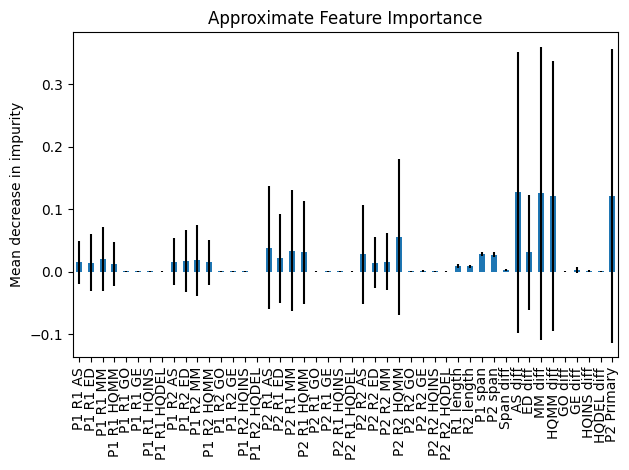

In [17]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
print(forest_importances)

P1 R1 AS       0.015613
P1 R1 ED       0.014950
P1 R1 MM       0.021052
P1 R1 HQMM     0.013387
P1 R1 GO       0.000718
P1 R1 GE       0.001183
P1 R1 HQINS    0.001123
P1 R1 HQDEL    0.000629
P1 R2 AS       0.016070
P1 R2 ED       0.017002
P1 R2 MM       0.018970
P1 R2 HQMM     0.015554
P1 R2 GO       0.000788
P1 R2 GE       0.001214
P1 R2 HQINS    0.001152
P1 R2 HQDEL    0.000273
P2 R1 AS       0.038997
P2 R1 ED       0.021755
P2 R1 MM       0.033808
P2 R1 HQMM     0.031438
P2 R1 GO       0.000656
P2 R1 GE       0.001123
P2 R1 HQINS    0.001074
P2 R1 HQDEL    0.000371
P2 R2 AS       0.028084
P2 R2 ED       0.014681
P2 R2 MM       0.016431
P2 R2 HQMM     0.055872
P2 R2 GO       0.000821
P2 R2 GE       0.001376
P2 R2 HQINS    0.001033
P2 R2 HQDEL    0.000424
R1 length      0.010165
R2 length      0.009176
P1 span        0.028432
P2 span        0.027833
Span diff      0.002683
AS diff        0.127149
ED diff        0.031799
MM diff        0.125729
HQMM diff      0.121496
GO diff        0